# Affective signals - IV (Heartbeat) # 
----
<span style="color:Blue">**Through this notebook we hope you get an hands on approach to the seminar. 
    Below you will find code snippets and theory that will help you apply the various libraries that have been introduced to you in the course.**</span>
    
<span style="color:Red">**For this notebook to run you need to update your docker.**</span> Please check back to the ReadMe file and execute the following command after starting the docker container: `docker exec -it -w /home/ jupyter_notebook bash -c "source ~/.bashrc; jupyter-notebook --no-browser --ip="*" --allow-root"`

In [12]:
pip install biosignalsnotebooks --force-reinstall

  Using cached biosignalsnotebooks-0.6.14-py3-none-any.whl.metadata (7.0 kB)
  Using cached numpy-1.22.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.0 kB)
  Using cached matplotlib-3.10.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached scipy-1.8.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (2.2 kB)
  Using cached h5py-3.12.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.5 kB)
  Using cached wget-3.2-py3-none-any.whl
  Using cached DateTime-5.5-py3-none-any.whl.metadata (33 kB)
  Using cached bokeh-2.4.3-py3-none-any.whl.metadata (14 kB)
  Using cached ipython-8.30.0-py3-none-any.whl.metadata (4.9 kB)
  Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached libmagic-1.0-py3-none-any.whl
INFO: pip is looking at multiple versions of biosignalsnotebooks to determine which version is compatible with other

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import biosignalsnotebooks as bsnb
import subprocess
import heartpy as hp

### Extraction
We will extract the data from the text files that you have recorded during the lab tour. Below you will have code cells which will guide you through the process of extracting the right segment of the signal that you will further use for processing. 

Note: Remember to place your video and ground truth data(data.txt, data.h5 and eventAnnotations.txt) in "/sose22_mbp_affective_signals/Notebooks/"

In [4]:
#path to the data that you recorded data(within the container)
filePath = "data.txt"

#function provided by biosignals to load data and header
data, header = bsnb.load(filePath, get_header=True)
sampling_rate = header["sampling rate"]

In [6]:
#information of the dataset
header

{'device': 'biosignalsplux',
 'device name': '00:07:80:4B:2C:2B',
 'device connection': 'BTH00:07:80:4B:2C:2B',
 'sampling rate': 300,
 'resolution': [16, 16, 16],
 'firmware version': 776,
 'comments': '',
 'keywords': '',
 'sync interval': 2,
 'date': '2024-11-20',
 'time': '16:25:38.42',
 'channels': [2, 3, 4],
 'sensor': ['ECG', 'RESPIRATION', 'BVP'],
 'digital IO': [0, 1],
 'sleeve color': ['green', 'yellow', 'white'],
 'convertedValues': 0,
 'column labels': {2: 2, 3: 3, 4: 4}}

In [50]:
#ECG data 
ECG_raw = data["CH2"]
respiratory_rate = data["CH3"]
time_stamps = bsnb.generate_time(ECG_raw, sampling_rate)
#convert ECG data to mv 
ch = "CH2" # Channel
sr = 300 # Sampling rate
vcc = 3000 # mV
gain = 1000
resolution = header['resolution'][0] # Resolution (number of available bits)
ECG_mv =  (((np.array(ECG_raw) / 2**resolution) - 0.5) * vcc) / gain

In [52]:
#plot of first 10seconds of the video, Both raw signal and in mV
bsnb.plot([time_stamps[0:10000], time_stamps[0:10000]], [ECG_raw[0:10000], ECG_mv[0:10000]], y_axis_label=["Raw Data", "Electric Voltage (mV)"],
          grid_lines=1, grid_columns=2, grid_plot=True)


In [19]:
def load_events(filepath):
    with open(eventFilePath)  as f:
        header = []
        data = []
        for i, line in enumerate(f.readlines()):
            if i < 3:
                if i == 1:
                    header.append(line)
            else:
                data.append(line.strip().split())
    return header, data

In [21]:
#path to the eventannotation file
eventFilePath = "eventAnnotation.txt"
header_ev, data_ev = load_events(eventFilePath)
data_ev

[['0007804B2C2B', 'A2', '1', '459.15', '459.15'],
 ['0007804B2C2B', 'A3', '1', '459.15', '459.15'],
 ['0007804B2C2B', 'A4', '1', '459.15', '459.15'],
 ['0007804B2C2B', 'IO1', '1', '459.15', '459.15'],
 ['0007804B2C2B', 'A2', '2', '607.95', '607.95'],
 ['0007804B2C2B', 'A3', '2', '607.95', '607.95'],
 ['0007804B2C2B', 'A4', '2', '607.95', '607.95'],
 ['0007804B2C2B', 'IO1', '2', '607.95', '607.95']]

Once you load the timestamps, you would be able to look at the time in seconds.There should be ideally two timestamps that indicate the start of your signals that you saved during the recording.

In [24]:
# update the values of the first timestamp and second timestamp from the values you observed in the event files
first_timestamp = 459.15
second_timestamp = 607.95
total_time = len(ECG_mv)/sampling_rate
first_point = int(sampling_rate*first_timestamp)
second_point = int(sampling_rate*second_timestamp)

In [26]:
#Normal heartrate , we use 60s after the first timestamp
timeNormalHR = time_stamps[first_point:first_point+60*sampling_rate]
ECGNormalHr = ECG_mv[first_point:first_point+60*sampling_rate]
bsnb.plot(timeNormalHR,ECGNormalHr,y_axis_label="Electric Voltage (mV)")

In [28]:
#elevatedHR 
timeElevatedHR = time_stamps[second_point:second_point+60*sampling_rate]
ecgElevatedHr = ECG_mv[second_point:second_point+60*sampling_rate]
bsnb.plot(timeElevatedHR,ecgElevatedHr, y_axis_label="Electric Voltage (mV)")

In [17]:
#starting timestamp for the video with elevated heartrate
start_video = int(np.round(time_stamps[second_point]- time_stamps[first_point]))

#convert the videos into 1 min snippets 
# pathVideo = "/data/ppg_22_bi_video_stud_lab/raw/P2/video.MOV"
pathVideo = "Bhautik.MOV"

subprocess.run(['ffmpeg', '-ss','10','-t','60','-i', pathVideo,  "./"+"NormalHR.mp4"])
subprocess.run(['ffmpeg', '-ss',f'{start_video+10}','-t','60','-i', pathVideo,  "./"+"ElevatedHR.mp4"])

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

CompletedProcess(args=['ffmpeg', '-ss', '160', '-t', '60', '-i', 'Bhautik.MOV', './ElevatedHR.mp4'], returncode=0)

### ECG, PPG and rPPG Signal

The ECG signal is directly derived from the electrical signal caused by the heart and produces this specific signal pattern shown in the following figure. 

PPG methods also have direct contact with the skin, however do not measure electrical signals but infra-red light reflections from the skin. The reflection varies depending on how much blood volume is present at a specific time in the tissue. 
Hence, PPG reflects a pulse signal with a different signal pattern than ECG. Both signals are highly correlated and can be analyzed to some part the same way. 





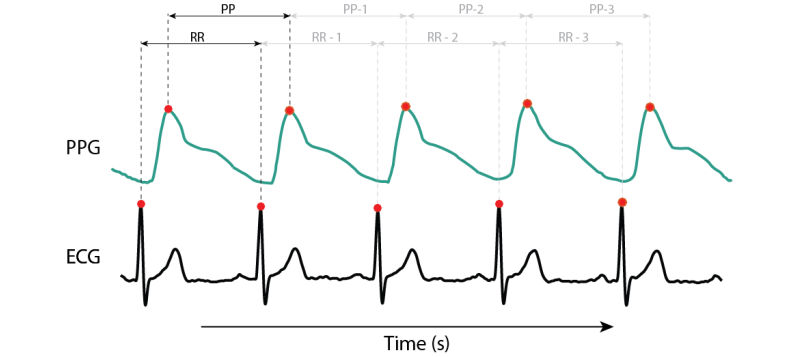[Source](https://www.empatica.com/blog/the-clinical-importance-of-heart-rate-variability.html)

### rPPG 


Remote PPG measures the variance of red, green and blue light reflections changes from the skin (specular reflection and diffused reflection). 
Specular reflection is the light reflection from the skin surface, which is modulated by motion and the skin surface itself. Diffuse reflection, in contrast, contains pulsatile information. It reflects absorption and scattering in skin tissue, which depends on blood volume changes. 
[Source](https://ieeexplore.ieee.org/abstract/document/7565547)



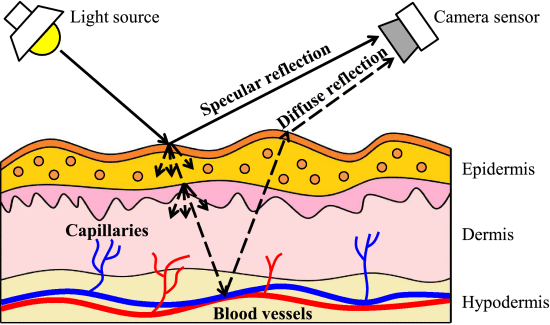


The rPPG signal slightly differs in its pattern compared to classical PPG signal but reflect the same information of blood volume pulse (BVP). 

Blood volume pulse is the volume of blood that passes through the vessels in an area with each beat of the heart (pulse).
The PPG signal (also rPPG) and BVP are similar measurements, meaning that the BVP signal results from high-pass filtering the PPG signal.

BVP peaks correspond with the R peaks of the ECG signal and hence can be used for heart rate variability (HRV) or in this case pulse rate variability (PRV) analysis.

The following figure shows their signal relationship: ECG-GT is the ground truth signal compared with rPPG. 

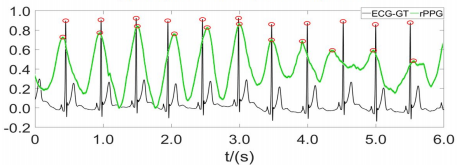
[Source](https://ieeexplore.ieee.org/document/9010965)

# [pyVHR](https://github.com/phuselab/pyVHR)

pyVHR stands for Python framework for Virtual Heart Rate and estimates beats per minute (bpm) by using the RGB-video data. A short overview of the framework is shown in the following figure. 

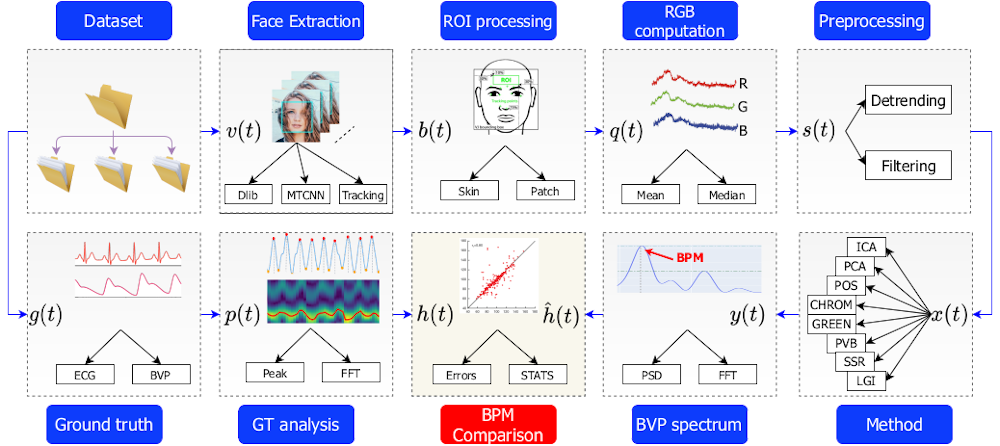

The framework uses different well-known rPPG methods (e.g.[POS](https://ieeexplore.ieee.org/document/7565547), [CHROM](https://ieeexplore.ieee.org/document/6523142), [Green](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2717852/), [PBV](https://pubmed.ncbi.nlm.nih.gov/25159049/) ) to estimate the respective blood volume pulse from RGB values, from which the bpm can be derived. 

First, the raw RGB data is preprocessed in order to suppress noise and artifacts. 

Then, the preprocessed signal is split into overlapped subsequences (chunks) in order to estimate a temporal sequence, the blood volume pulse (BVP), based on the respective rPPG method.

The BVP signal of the respective chunks is used to calculate bpm. Spectral analysis, in this case, Power Spectral Density (PSD) is performed to evaluate the power distribution as a function of frequency, hence to get the underlying bpm frequency.  

The below code cell provides a function to all the required steps as mentioned above.
First, we need to extract cropped face images from the video by using a pretrained face detection model: 

Additionally, you get some general information about your video file.

Note: The processing would take up to 10-20 minutes.

In [20]:
pip install mediapipe

  Using cached numpy-1.26.4-cp39-cp39-macosx_10_9_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 MB 4.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 MB 7.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 8.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 7.0 MB/s eta 0:00:0000:0100:01
Using cached numpy-1.26.4-cp39-cp39-macosx_10_9_x86_64.whl (20.6 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.2
    Uninstalling numpy-1.22.2:
      Successfully uninstalled numpy-1.22.2
  Attempting uninstall: sc

## Sections below this block are throwing errors every time and my jupyter kernel keeps dying automatically, I tried multiple solutions but nothing is working out so I have not explored further.

In [ ]:
import configparser
import ast
from numpy.lib.arraysetops import isin
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from importlib import import_module, util
from pyVHR.datasets.dataset import datasetFactory
from pyVHR.utils.errors import getErrors, printErrors, displayErrors
from pyVHR.extraction.sig_processing import *
from pyVHR.extraction.sig_extraction_methods import *
from pyVHR.extraction.skin_extraction_methods import *
from pyVHR.BVP.BVP import *
from pyVHR.BPM.BPM import *
from pyVHR.BVP.methods import *
from pyVHR.BVP.filters import *
import time
from inspect import getmembers, isfunction
import os.path

#function slightly modified from https://github.com/phuselab/pyVHR/blob/pyVHR_CPU/pyVHR/analysis/pipeline.py
def run_on_video(videoFileName, roi_method='convexhull', roi_approach='holistic', method='cupy_POS', bpm_type='welch', pre_filt=False, post_filt=True, verb=True):
        """ 
        Runs the pipeline on a specific video file.

        Args:
            videoFileName:
                - The path to the video file to analyse
            roi_method:
                - 'convexhull' - Uses MediaPipe's lanmarks to compute the convex hull of the face and segment the skin
                - 'faceparsing' - Uses BiseNet to parse face components and segment the skin
            roi_approach:
                - 'holistic' - Use the Holistic approach (one single ROI defined as the whole face skin region of the subject)
                - 'patches' - Use multiple patches as Regions of Interest
            method:
                - One of the rPPG methods defined in pyVHR
            bpm_type:
                - the method for computing the BPM estimate on a time window
            pre_filt:
                - True - Use Band pass filtering on the windowed RGB signal
                - False - No pre-filtering
            post_filt:
                - True - Use Band pass filtering on the estimated BVP signal
                - False - No post-filtering
            verb:
               - False - not verbose
               - True - show the main steps  
        """
#         ldmks_list = [2, 3, 4, 5, 6, 8, 9, 10, 18, 21, 32, 35, 36, 43, 46, 47, 48, 50, 54, 58, 67, 68, 69, 71, 92, 93, 101, 103, 104, 108, 109, 116, 117, 118, 123, 132, 134, 135, 138, 139, 142, 148, 149, 150, 151, 152, 182, 187, 188, 193, 197, 201, 205, 206, 207, 210, 211, 212, 216, 234, 248, 251, 262, 265, 266, 273, 277, 278, 280, 284, 288, 297, 299, 322, 323, 330, 332, 333, 337, 338, 345, 346, 361, 363, 364, 367, 368, 371, 377, 379, 411, 412, 417, 421, 425, 426, 427, 430, 432, 436]
        assert os.path.isfile(videoFileName), "\nThe provided video file does not exists!"
        
        sig_processing = SignalProcessing()
        av_meths = getmembers(pyVHR.BVP.methods, isfunction)
        available_methods = [am[0] for am in av_meths]

        assert method in available_methods, "\nrPPG method not recognized!!"
        
        # set skin extractor
        if roi_method == 'convexhull':
            sig_processing.set_skin_extractor(
                SkinExtractionConvexHull())
        elif roi_method == 'faceparsing':
            sig_processing.set_skin_extractor(
                SkinExtractionFaceParsing())
        else:
            raise ValueError("Unknown 'roi_method'")
        
        assert roi_approach == 'patches' or roi_approach=='holistic', "\nROI extraction approach not recognized!"
        
        # set patches
        if roi_approach == 'patches':
            #ldmks_list = ast.literal_eval(landmarks_list)
            #if len(ldmks_list) > 0:
            sig_processing.set_landmarks(ldmks_list)
            # set squares patches side dimension
            sig_processing.set_square_patches_side(28.0)
        
        # set sig-processing and skin-processing params
        SignalProcessingParams.RGB_LOW_TH = 75
        SignalProcessingParams.RGB_HIGH_TH = 230
        SkinProcessingParams.RGB_LOW_TH = 75
        SkinProcessingParams.RGB_HIGH_TH = 230

        if verb:
            print('\nProcessing Video: ' + videoFileName)
        fps = get_fps(videoFileName)
        print("The fps of the video is: ", fps)
        sig_processing.set_total_frames(0)

        # -- ROI selection
        sig = []
        if roi_approach == 'holistic':
            # SIG extraction with holistic
            sig = sig_processing.extract_holistic(videoFileName)
        elif roi_approach == 'patches':
            # SIG extraction with patches
            sig = sig_processing.extract_patches(videoFileName, 'squares', 'mean')

        # -- sig windowing
        windowed_sig, timesES = sig_windowing(sig, 10, 1, fps)

        # -- PRE FILTERING
        filtered_windowed_sig = windowed_sig

        # -- color threshold - applied only with patches
        if roi_approach == 'patches':
            filtered_windowed_sig = apply_filter(windowed_sig,
                                                 rgb_filter_th,
                                                 params={'RGB_LOW_TH':  75,
                                                         'RGB_HIGH_TH': 230})

        if pre_filt:
            module = import_module('pyVHR.BVP.filters')
            method_to_call = getattr(module, 'BPfilter')
            bvps = apply_filter(filtered_windowed_sig,
                                method_to_call, 
                                fps=fps, 
                                params={'minHz':0.65, 'maxHz':4.0, 'fps':'adaptive', 'order':6})
        if verb:
            print("\nBVP extraction with method: %s" % (method))

        # -- BVP Extraction
        module = import_module('pyVHR.BVP.methods')
        method_to_call = getattr(module, method)
        if 'cpu' in method:
            method_device = 'cpu'
        elif 'torch' in method:
            method_device = 'torch'
        elif 'cupy' in method:
            method_device = 'cuda'

        if 'POS' in method:
            pars = {'fps':'adaptive'}
        elif 'PCA' in method or 'ICA' in method:
            pars = {'component': 'all_comp'}
        else:
            pars = {}

        bvps = RGB_sig_to_BVP(windowed_sig, fps,
                              device_type=method_device, method=method_to_call, params=pars)

        # -- POST FILTERING
        if post_filt:
            module = import_module('pyVHR.BVP.filters')
            method_to_call = getattr(module, 'BPfilter')
            bvps = apply_filter(bvps, 
                                method_to_call, 
                                fps=fps, 
                                params={'minHz':0.65, 'maxHz':4.0, 'fps':'adaptive', 'order':6})

        if verb:
            print("\nBPM estimation with: %s" % (bpm_type))
        # -- BPM Estimation
        if bpm_type == 'welch':
                bpmES = BVP_to_BPM(bvps, fps, minHz=0.65, maxHz=4.0)
        elif bpm_type == 'clustering':
                bpmES = BVP_to_BPM_PSD_clustering(bvps, fps, minHz=0.65, maxHz=4.0)
        else:
            raise ValueError("Unknown 'bpm_type'")

        # median BPM from multiple estimators BPM
        median_bpmES, mad_bpmES = multi_est_BPM_median(bpmES)

        if verb:
            print('\n...done!\n')
        return timesES, median_bpmES, bvps

In [ ]:
#names of the files that were created
normaHRPath = "./NormalHR.mp4"
ElevatedHRPath = "./ElevatedHR.mp4"

In [2]:
'''List of available methods
cpu_LGI,cpu_POS,cpu_PBV,cpu_PCA,cpu_GREEN,cpu_OMIT,cpu_ICA,cpu_SSR
'''
#using classical methods to get the Heartrate
times, bpmES, bvps = run_on_video(normaHRPath, method='cpu_POS')

NameError: name 'run_on_video' is not defined

In [15]:
'''Addtional functions to save and load your BPM estimations'''
import h5py
def save_results(name, times,bmpES,bvps):
    hf = h5py.File(name+".h5", 'w')
    hf.create_dataset('times', data=times)
    hf.create_dataset('bpmES', data=bmpES)
    hf.create_dataset('bvps', data=bvps)
    hf.close()
    
def load_results(name):
    hf = h5py.File(name, 'r')
    bmpES = np.array(hf.get('bpmES'))
    times = np.array(hf.get('times'))
    bvps = np.array(hf.get('bvps'))
    return bmpES, times, bvps

# example of how to use the function
# save_results("cpu_pos",times,bpmES,bvps)
# bmpsES, timeES, bvps = load_results("cpu_pos.h5")

#### Task 4.1 As show above, try out at least two methods to get the HR values (e.g. cpu_green, cpu_PCA) and on both videos. Plot these values , report the differences that you can observe. 

In [20]:
###############################
#     your code goes here     #
###############################

''' There are functions provided to save the results for each run that you carry out'''

# Would take about 10 mins to run per method


' There are functions provided to save the results for each run that you carry out'

#### Task 4.2: Have a look at your heart rate over time and use what you learned in the lecture to see if they make sense. what are the differences you observer between all the different methods that you used. Also talk about what are the specific things that you would expect to see between the two videos w.r.t the change in heart rate. 

Your observations go here:

#### We also have the ground truth estimations(ECG), we use these to estimate the HR. 
since we use segmented signals to calculate the HR at different time points, a similar approach segmented approach must be used in estimating the heartrate from the ECG signal.

In [8]:
working_data_El, measures_El = hp.process_segmentwise(ecgElevatedHr, sample_rate=1000, segment_width = 10, segment_overlap = 0.90,mode="full")
working_data_Nr, measures_Nr = hp.process_segmentwise(ECGNormalHr, sample_rate=1000, segment_width = 10, segment_overlap = 0.90,mode="full")

# '''addtional method to calcualte ecg'''
# from pyVHR.utils.ecg import ECGsignal
# signal = ECGsignal(ecgElevatedHr, 1000)
# bpmGT, timeGT = signal.getBPM(winsize=10)

NameError: name 'hp' is not defined

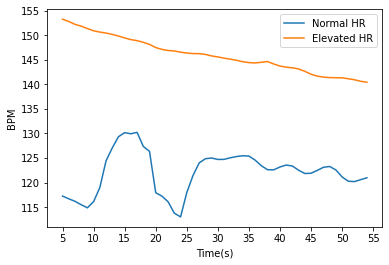

In [71]:
#The Bmp of the entire signal is stored in the dict:measures_El and measures_Nr
#Both the classical methods and the ground truth are extracted from 
#overlapping windows of length 10s. 
xticks = np.arange(5,55,1)
plt.plot(xticks,measures_Nr['bpm'], label="Normal HR")
plt.plot(xticks, measures_El['bpm'], label="Elevated HR")
plt.ylabel("BPM")
plt.xlabel("Time(s)")
plt.xticks(range(5,60,5))
plt.legend()
plt.show()

#### Task 4.3:Use the evaluation metrics( MAE and RMSE) to compare the various methods that you have tried out.

In [ ]:
###############################
#     your code goes here     #
###############################

# you can use built in funcitons or write your own funtions to calculate the MAE and RMSE.



#### Task 4.4: Write a short report based on the evalutation metrics on which method performed the best.
- Discuss the changes that you see between the elevated heartrate and normalheart rate videos. Is the performance of the the rPPG methods better on elevated HR or normal HR. 
- Bonus Task: Calculate the mean of the HR and use this value as dummy estimate. Using this value calculate the different metrics.Compare the metrics from the dummy classifier with the metrics calculated for the the classical methods. 

A nice article on why you need a [dummy estimator](https://towardsdatascience.com/why-using-a-dummy-classifier-is-a-smart-move-4a55080e3549)

In [ ]:
Your analysis goes here: 

# HRV

Heart rate variability (HRV) is the variation in the time interval between adjacent heart beats (R peaks), and is modulated by various factors as seen in the seminar. The main physiological modulators are sympathicus and parasympathicus, which either increase the heart rate and lowers the RR variability (low HRV) or decrease the heart rate and increase the RR variability (high HRV).

### Normal HR

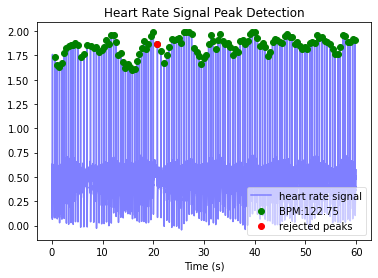

In [82]:
working_data_Nr, measures_Nr = hp.process(ECGNormalHr, 1000.0)
#using RR intervals for further analysis
RR_interval_Nr = working_data_Nr['RR_list']

#plot of RR-interval
hp.plotter(working_data_Nr, measures_Nr)

In [83]:
# outlier filtering

# remove RR intervals which are smaller than 0,3 and bigger than 2 sec (both are physiological impossible)
# use the histogram also for outlier detection
RR_interval_Nr = [element for element in RR_interval_Nr if  2000> element >300]

Text(0.5, 1.0, 'RR interval histogram')

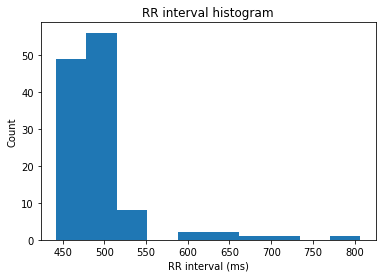

In [84]:
# RR interval histrogram visualization
plt.hist(RR_interval_Nr)
plt.xlabel('RR interval (ms)')
plt.ylabel('Count')
plt.title('RR interval histogram')

### Elevated HR

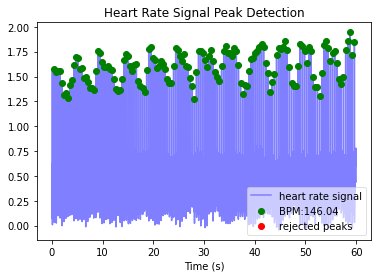

In [94]:
working_data_El, measures_El = hp.process(ecgElevatedHr, 1000.0)
#using RR intervals for further analysis
RR_interval_El = working_data_El['RR_list']
#plot of RR-interval
hp.plotter(working_data_El, measures_El)

In [95]:
# outlier filtering

# remove RR intervals which are smaller than 0,3 and bigger than 2 sec (both are physiological impossible)
# use the histogram also for outlier detection
RR_interval_El = [element for element in RR_interval_El if  2000> element >300]

Text(0.5, 1.0, 'RR interval histogram')

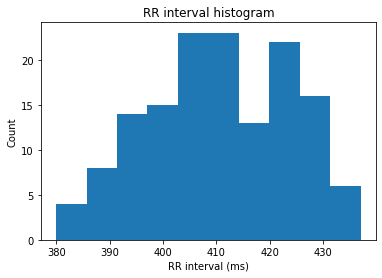

In [96]:
# RR interval histrogram visualization
plt.hist(RR_interval_El)
plt.xlabel('RR interval (ms)')
plt.ylabel('Count')
plt.title('RR interval histogram')

# Time-Domain Analysis

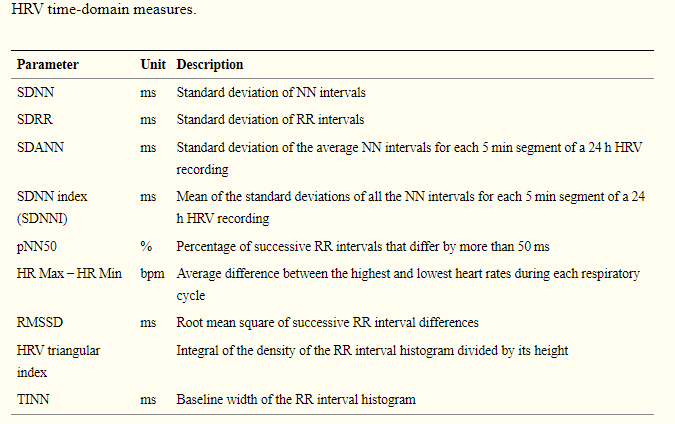 [Source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/)

In [97]:
from hrvanalysis import get_time_domain_features
import pandas as pd

time_domain_features_Nr = get_time_domain_features(RR_interval_Nr)
time_domain_features_El = get_time_domain_features(RR_interval_El)
list_of_features = ["mean_nni", "pnni_50", "rmssd","median_nni","range_nni","mean_hr","max_hr","min_hr"]
time_domain_features_Nr = {k:v for k,v in time_domain_features_Nr.items() if k in list_of_features}
time_domain_features_El = {k:v for k,v in time_domain_features_El.items() if k in list_of_features}

time_domain_features = {}
time_domain_features["Normal HR"] = time_domain_features_Nr
time_domain_features["Elevated HR"] = time_domain_features_El

pd.DataFrame(time_domain_features)

,Normal HR,Elevated HR
mean_nni,493.283333,410.833333
pnni_50,6.722689,0.000000
rmssd,35.364726,2.460883
median_nni,483.000000,411.500000
range_nni,365.000000,57.000000
mean_hr,122.628753,146.195150
max_hr,135.746606,157.894737
min_hr,74.349442,137.299771


#### Task 4.5: Compare the time-domain features calculated from both the normal heart rate and elevated heartrate

Your interesting findings:

# Frequency Domain Analysis

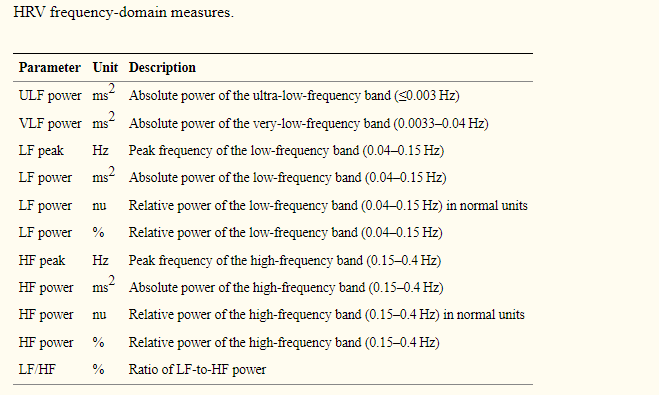[Source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/)

In PPV spectral analysis, power spectral density (PSD) can be used to extract low (0,04-0,15 Hz) and high (0,15-0,4 Hz) frequencies. Certain frequency bands correlate with physiological processes, which provide information about the interplay of the autonomic nervous system.
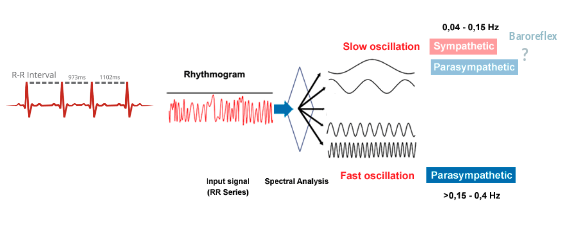

[Source](https://lernraumplus.uni-bielefeld.de/pluginfile.php/736948/mod_resource/content/1/8_affective_signals_heart_processing_prelim.pdf)

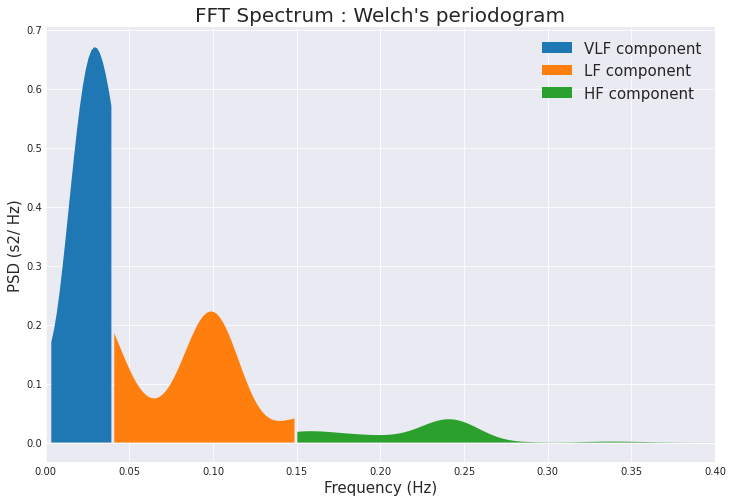

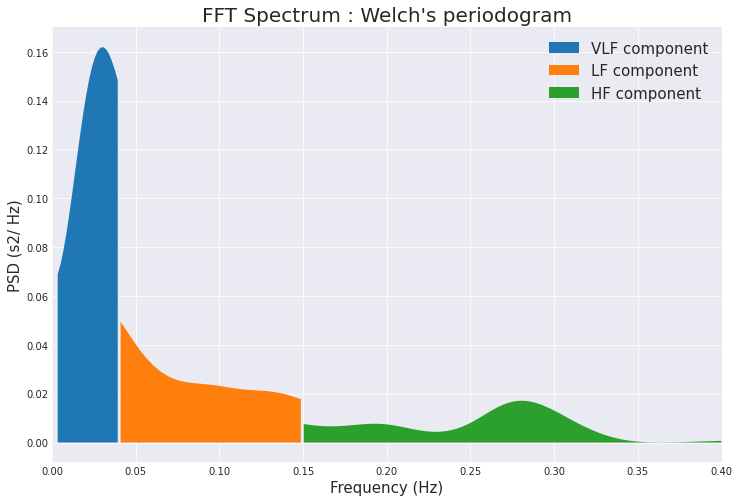

In [101]:
from hrvanalysis import plot_psd
plot_psd(RR_interval_Nr, method="welch")
plot_psd(RR_interval_El, method="welch")

In [79]:
from hrvanalysis import get_frequency_domain_features

frequency_domain_features_Nr = get_frequency_domain_features(RR_interval_Nr)
frequency_domain_features_El = get_frequency_domain_features(RR_interval_El)


list_of_features = ["hf", "total_power", "lf","hf","lf_hf_ratio"]
frequency_domain_features_Nr = {k:v for k,v in frequency_domain_features_Nr.items() if k in list_of_features}
frequency_domain_features_El = {k:v for k,v in frequency_domain_features_El.items() if k in list_of_features}

frequency_domain_features = {}
frequency_domain_features["Normal HR"] = frequency_domain_features_Nr
frequency_domain_features["Elevated HR"] = frequency_domain_features_El

pd.DataFrame(frequency_domain_features)

/miniconda/envs/pyvhr/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 235, using nperseg = 235
  warnings.warn('nperseg = {0:d} is greater than input length '
/miniconda/envs/pyvhr/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 236, using nperseg = 236
  warnings.warn('nperseg = {0:d} is greater than input length '


,Normal HR,Elevated HR
lf,1534.073397,7.083811
hf,1098.477319,15.207488
lf_hf_ratio,1.396545,0.465811
total_power,2837.039404,47.721601


#### Task 4.6: Compare the Frequency-domain features calculated from both the normal heart rate and elevated heartrate

Your interesting findings:

### Poincaré Plots
The parameter (SD1) is the measure of the standard deviation of instantaneous
beat-to-beat interval variability and (SD2) is that of the continuous long-
term RR interval variability

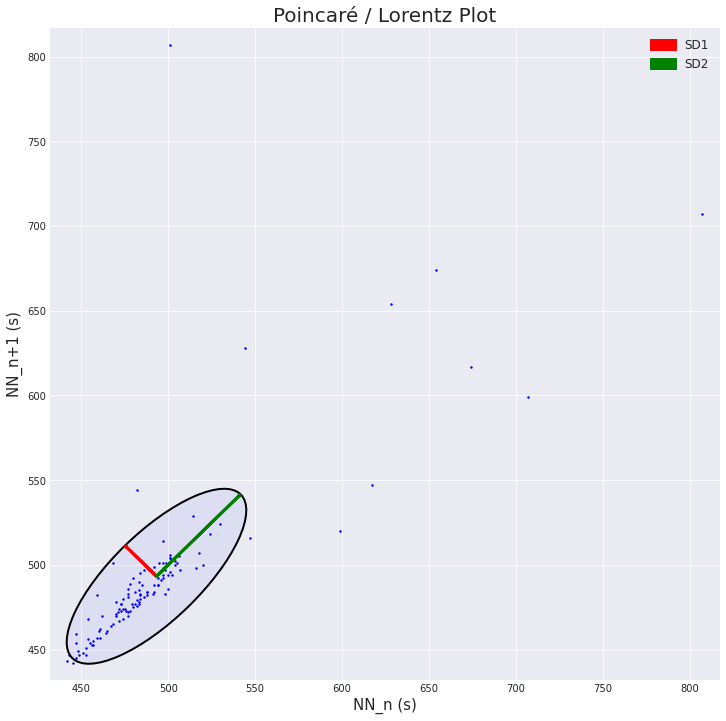

Normal Hr SD1 12.014351492922186, SD2, 50.89339296980107


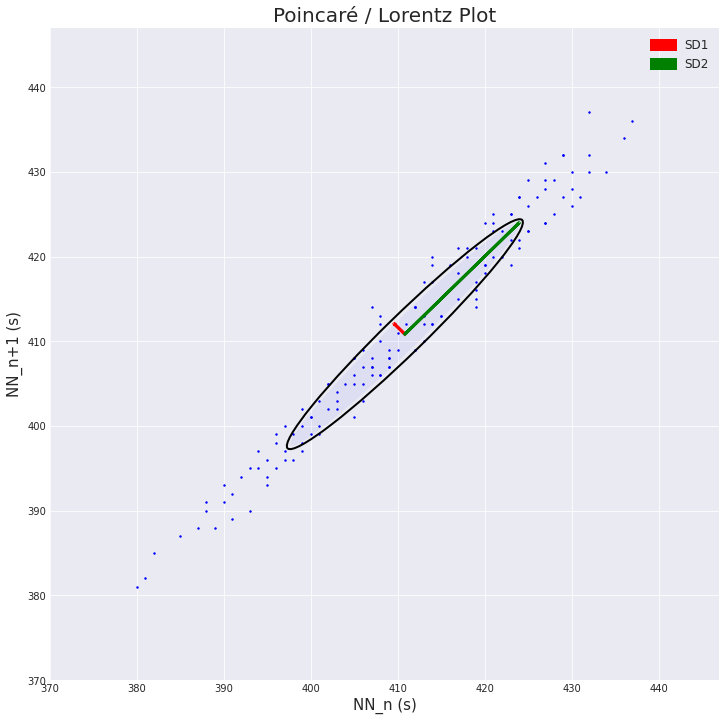

Normal Hr SD1 1.7251763842149987, SD2, 18.33972713732311


In [102]:
from hrvanalysis import plot_poincare
plot_poincare(RR_interval_Nr)
print(f"Normal Hr SD1 {measures_Nr['sd1']}, SD2, {measures_Nr['sd2']}")
plot_poincare(RR_interval_El)
print(f"Normal Hr SD1 {measures_El['sd1']}, SD2, {measures_El['sd2']}")
